In [29]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image


In [30]:
# Provided Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def get_patches(im, w, h, padding):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight-padding*2,h):
        for j in range(0,imgwidth-padding*2,w):
            if is_2d:
                im_patch = im[j:j+w+padding*2, i:i+h+padding*2]
            else:
                im_patch = im[j:j+w+padding*2, i:i+h+padding*2, :]
            list_patches.append(im_patch)
    return list_patches

def patch_to_label(patch):
    foreground_threshold = 0.25
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
# tf 

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg
    
# Added helpers

def pad_image(image, padding):
    padded_image = np.lib.pad(image, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return padded_image

def pad_list_image(images, padding):
    padded_images = []
    for i in range(len(images)):
        image = pad_image(images[i], padding)
        padded_images.append(image)
    
    return padded_images
        
def save_labels_to_images(imgwidth, imgheight, w, h, labels):
    patch_per_image = int(imgwidth / w) * int(imgheight/h)
    count = int(len(labels) / patch_per_image)
    
    for i in range(count):
        img = label_to_img(imgwidth, imgheight, w, h, labels[i*patch_per_image:(i+1)*patch_per_image])
        im = Image.fromarray(img_float_to_uint8(img))
        prediction_test_dir = "predictions/"
        print("Saving " + prediction_test_dir + "prediction_" + str(i+1) + ".png")
        im.save(prediction_test_dir + "prediction_" + str(i+1) + ".png")
        
def display_prediction_and_gt(model, X, Y, image_size, patch_size, image_index):
    patch_count_per_image = int((image_size / 16) ** 2) 
    fig1 = plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    predictions = model.predict_classes(X[image_index * patch_count_per_image: (image_index+1) * patch_count_per_image])
    img = label_to_img(image_size, image_size, patch_size, patch_size, predictions)
    plt.imshow(img, cmap='Greys_r');
    plt.subplot(1, 2, 2)
    img = label_to_img(image_size, image_size, patch_size, patch_size, Y[image_index * patch_count_per_image: (image_index+1) * patch_count_per_image])
    plt.imshow(img, cmap='Greys_r');
        

## Load the data

In [31]:
# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 100 # Only use 10 images for training

Loading 100 images
satImage_001.png
Loading 100 groundtruth
satImage_001.png


## Data Exploration

Image size = 400,400


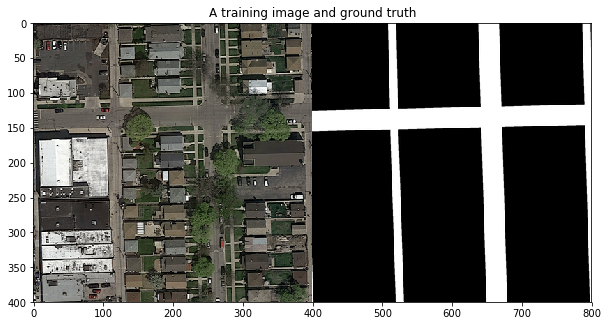

In [32]:
image = imgs[3]
gt_image = gt_imgs[3]
print('Image size = ' + str(image.shape[0]) + ',' + str(image.shape[1]))
fig1 = plt.figure(figsize=(10, 10))
plt.title("A training image and ground truth")
plt.imshow(concatenate_images(image, gt_image), cmap='Greys_r');


We observe that the road we need to label can be a difficult task. The variety of colors and obstacles is high : 
- Trees
- Cars
- Asphalt color

There are 625 patches of 16*16 for the image


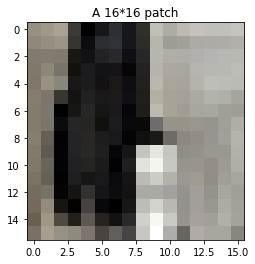

In [33]:
patch_size = 16
img_patches = get_patches(image, patch_size, patch_size, 0)
plt.title('A 16*16 patch')

print("There are", len(img_patches), "patches of 16*16 for the image")
plt.imshow(img_patches[5], cmap='Greys_r');

Our task is to label each of these 16\*16 patch.  
On the example above can be either some obstacle, a car, or an element of a roof.


However, this small size of portion of the image can miss some context. We need to expand this by adding some padding around it. 


## Padding

Instead of taking the raw 16\*16 patch, we can take a larger patch (padded patch) and then classify the 16\*16 center of that expanded patch.

In order to do that on the border of the image, we have to expand it. One of the way to do that is to mirroring the image

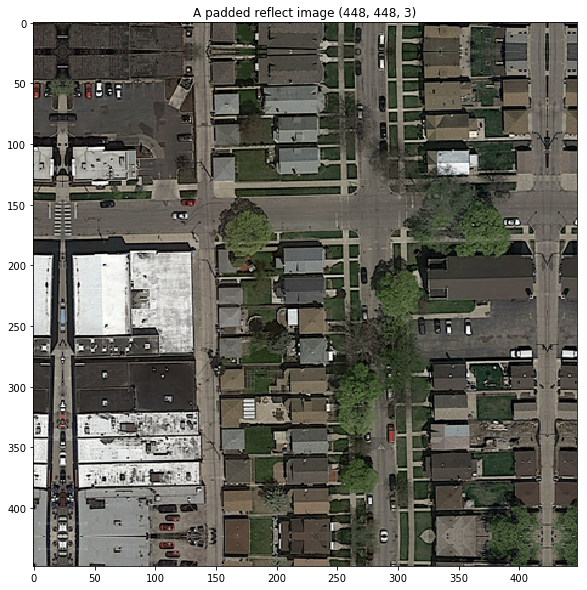

In [34]:
image = imgs[3]
gt_image = gt_imgs[3]

padding = 24
padded_patch_size = patch_size + padding * 2

padded_image = pad_image(image, padding)

fig1 = plt.figure(figsize=(10, 10))
plt.title("A padded reflect image " + str(padded_image.shape))
plt.imshow(padded_image, cmap='Greys_r');

There are 625 patches of 64*64 for the image


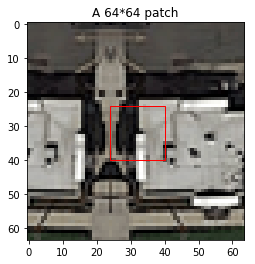

In [35]:
padded_img_patches = get_patches(padded_image, patch_size, patch_size, padding)

print("There are", len(padded_img_patches), 'patches of ' + str(padded_patch_size) + '*' +  str(padded_patch_size) + ' for the image')


fig,ax = plt.subplots(1)
plt.title('A ' + str(padded_patch_size) + '*' +  str(padded_patch_size) + ' patch')

plt.imshow(padded_img_patches[5], cmap='Greys_r');
rect = matplotlib_patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

Now we can see clearly that the center (the image inside the red square)of this padded image is not a road.

## Data augmentation
The dataset contains only 100 examples.
In order to increase the dataset, we can do the following transformation : 
- 90 degree rotation
- Horizontal flip
- Vertical flip

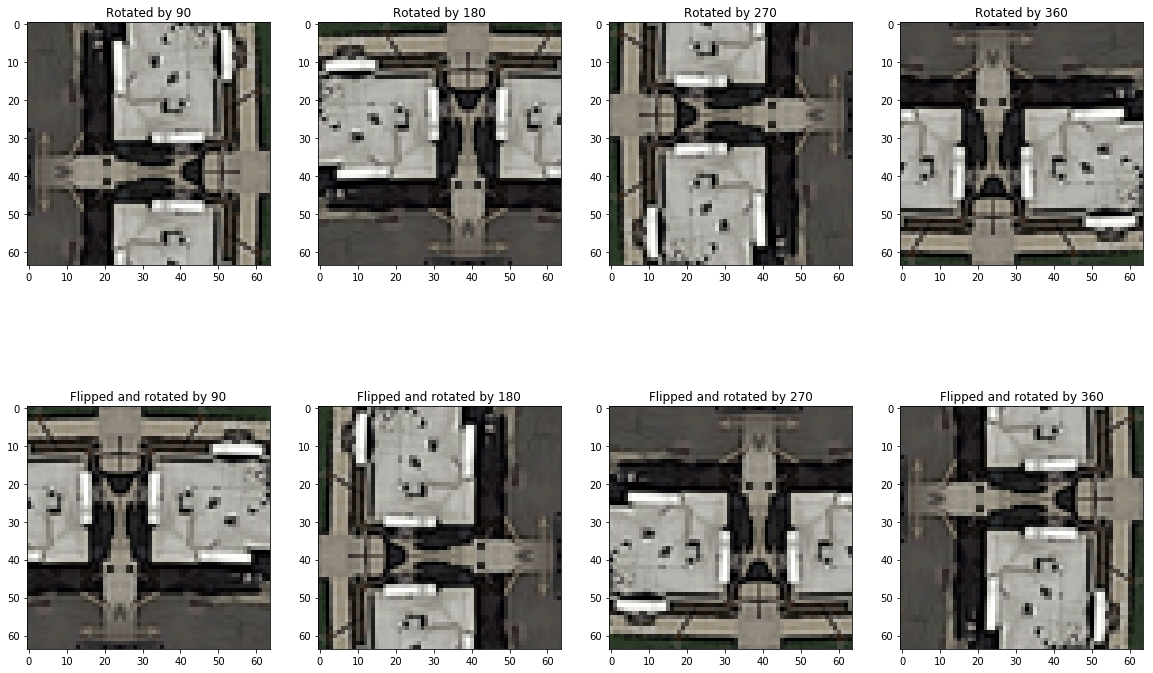

In [36]:
image_to_transform = padded_img_patches[5]
transformed_images = [np.rot90(image_to_transform, i+1) for i in range(4)]

for i in range(4):
    transformed_images.append(np.rot90(np.flip(image_to_transform, 0), i))


plt.figure(figsize=(20,20))
columns = 4
for i, transformed_image in enumerate(transformed_images):
    plt.subplot(len(transformed_images) / columns + 1, columns, i + 1)
    
    if i < 4:
        plt.title('Rotated by ' +str((i+1)*90))
    else:
        plt.title('Flipped and rotated by ' +str((i-3)*90))
    
    plt.imshow(transformed_image)

## X and Y
We create our training set.
- X : array of list of all patches
- Y : array of corresponding label

In [37]:
padded_images = pad_list_image(imgs, padding)
patches = [get_patches(image, patch_size, patch_size, padding) for image in padded_images]
patches = [patch for image_patches in patches for patch in image_patches] # Flatten the array of patches to array of patch

gt_patches = [get_patches(gt_image, patch_size, patch_size, 0) for gt_image in gt_imgs]
gt_patches = [patch for image_patches in gt_patches for patch in image_patches] # Flatten (same thing)

print("There are", len(gt_patches), "patches")

There are 62500 patches


We display an example to ensure our X and Y creation is correct

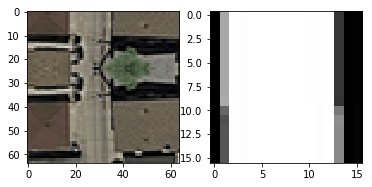

In [38]:
patch_size = 16
gt_img_patches = get_patches(gt_image, patch_size, patch_size, 0)

patch_index = 525

plt.subplot(1, 2, 1)
plt.imshow(patches[patch_index], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(gt_patches[patch_index], cmap='Greys_r');

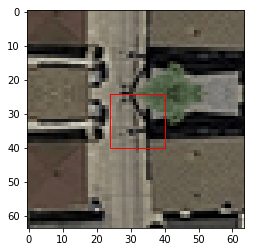

In [39]:
fig,ax = plt.subplots(1)
ax.imshow(patches[patch_index])
rect = matplotlib_patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

We create our X and Y variable. The Y is created by transforming each grount truth patch image to a numeric integer (1=road or 0=none)

In [13]:
X = np.array(patches)
Y = np.array(list(map(lambda x: patch_to_label(x), gt_patches)))

In [40]:
# Add rotation
initial_count = len(X)
for i in range(initial_count):
    x = X[i]
    y = Y[i]
    X = np.concatenate((X, np.array([np.rot90(x, 1)]))) # 90 degree
    X = np.concatenate((X, np.array([np.rot90(x, 2)]))) # 180 degree
    Y = np.append(Y, y)
    Y = np.append(Y, y)

MemoryError: 

## Building the convolutional neural network

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import rmsprop
import keras

input_shape = X[0].shape

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



Using TensorFlow backend.


In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

c:\users\coac\anaconda3\lib\site-packages\keras\preprocessing\image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


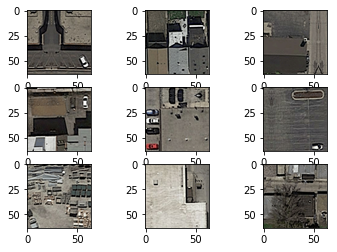

In [21]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zca_whitening=True, horizontal_flip=True, vertical_flip=True)
# datagen.fit(X)
train_generator = datagen.flow(x_train, y_train, batch_size=16)
for X_batch, y_batch in train_generator:
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [23]:
epochs = 1
batch_size = 16

# model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True)

model.fit_generator(train_generator, 
                   epochs=epochs,
                   validation_data=(x_test, y_test),
                   steps_per_epoch=2000,
                   shuffle=True)

Epoch 1/1
   2/2000 [..............................] - ETA: 5:11 - loss: 0.6736 - acc: 0.6562

c:\users\coac\anaconda3\lib\site-packages\keras\preprocessing\image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 111/2000 [>.............................] - ETA: 2:57 - loss: 0.5563 - acc: 0.7235

KeyboardInterrupt: 

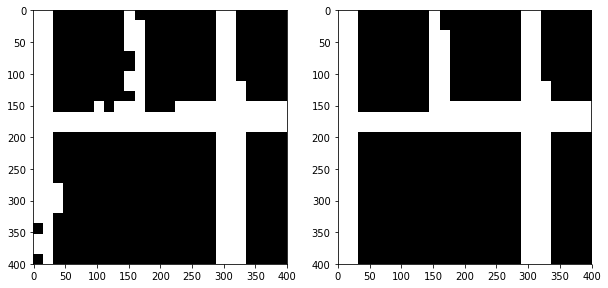

In [54]:
display_prediction_and_gt(model, X, Y, 400, patch_size, 2)

In [55]:
predictions = model.predict_classes(X[:625*3])
save_labels_to_images(400, 400, patch_size, patch_size, predictions)

Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png


## Test data

In [35]:
# Free some memory
del predictions
del padded_images
del patches
del X
del Y

NameError: name 'padded_images' is not defined

In [56]:
TEST_IMG_SIZE = 608

In [57]:
test_dir = "datas/test_set_images/"
files = os.listdir(test_dir)
n = min(100, len(files)) # Load maximum 20 images
files.sort()
print("Loading " + str(n) + " images")
test_imgs = [load_image(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0]) for i in range(n)]
print("Loaded !")

Loading 50 images
Loaded !


In [58]:
test_padded_images = pad_list_image(test_imgs, padding)
test_patches = [get_patches(image, patch_size, patch_size, padding) for image in test_padded_images]
test_patches = [patch for image_patches in test_patches for patch in image_patches] # Flatten the array of patches to array of patch

test_X = np.array(test_patches)

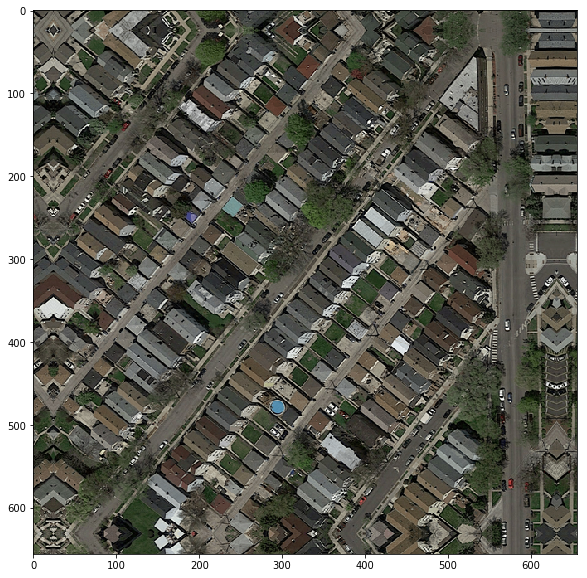

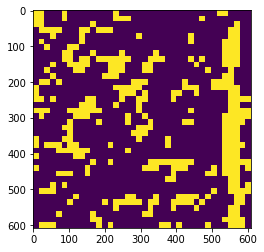

In [59]:
plt.figure(figsize=(10, 10))
plt.imshow(test_padded_images[len(test_padded_images)-1]);
plt.show()
test_label = label_to_img(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, model.predict_classes(test_X[-1444:]))
plt.imshow(test_label);

In [60]:
predictions = model.predict_classes(test_X)
save_labels_to_images(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, predictions)

Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png
Saving predictions/prediction_4.png
Saving predictions/prediction_5.png
Saving predictions/prediction_6.png
Saving predictions/prediction_7.png
Saving predictions/prediction_8.png
Saving predictions/prediction_9.png
Saving predictions/prediction_10.png
Saving predictions/prediction_11.png
Saving predictions/prediction_12.png
Saving predictions/prediction_13.png
Saving predictions/prediction_14.png
Saving predictions/prediction_15.png
Saving predictions/prediction_16.png
Saving predictions/prediction_17.png
Saving predictions/prediction_18.png
Saving predictions/prediction_19.png
Saving predictions/prediction_20.png
Saving predictions/prediction_21.png
Saving predictions/prediction_22.png
Saving predictions/prediction_23.png
Saving predictions/prediction_24.png
Saving predictions/prediction_25.png
Saving predictions/prediction_26.png
Saving predictions/prediction_27.png
Saving pre